<a href="https://colab.research.google.com/github/kris-aid/Deep-Learning/blob/main/Copia_de_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive # Cargar las imagenes desde el drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#cargamos algunas librerias
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import seaborn as sn
import seaborn as sns
import sklearn.metrics as metrics

In [ ]:
#Some global Variables
N=1000 #states the number of images from the that sets to be loaded.
classes={0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),
         1:('bcc' , 'basal cell carcinoma'),
         2:('bkl', 'benign keratosis-like lesions'),
         3:('df', 'dermatofibroma'),
         4:('nv', ' melanocytic nevi'),
         5:('vasc', ' pyogenic granulomas and hemorrhage'),
         6:('mel', 'melanoma'),} #Define a dictionary containg the labes for the clases for our model, which contains the different types of cancer
num_classes=7

In [ ]:
#function to get the size of my dataframes
def get_df_shape(data_frame):
  print("Data set shape: ", "\n # of rows: ", data_frame.shape[0],
        "\n # of columns: ", data_frame.shape[1], "\n")

In [ ]:
#Test code for dictionary
print([classes[0 ]])

[('akiec', 'actinic keratoses and intraepithelial carcinomae')]


In [ ]:
import cv2
import os
import glob
import re
images_list=[] #lista de imagenes
images_listname=[] #lista del nombre de las imagenes
# se define una expresion regular para tomar el nombre de cada imagen cargada dado su path, para luego juntarle su respectiva label
pattern = r'[^/]+$'
SIZE=14 # se define el tamaño al que se adaptara la imagen
path="/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_1/*.*" # path de la carpeta con las imagenes
path2="/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_2/*.*"
#The first folder woth images dind't upload completely I'll use the 2 folder containing images for procesing

if glob.glob(path): #verificacion de que esxista la carpeta
    print("Path exists.")
else:
    print("Path does not exist. Please check the path.")

for f in glob.glob(path): #carga las imagenes hasta la numero N debido a la memoria limitada
  img=cv2.imread(f) #carga la imagen desde la carpeta
  img=cv2.resize(img,(SIZE,SIZE)) #resize de la imagen
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # aseguramos que la imagen se cargue en RGB
  images_list.append(img) #añadimos la imagen a la lista de imagenes
  matches = re.search(pattern, f) # busca la seccion del string(path) que cumple con la expresion regular
  if matches:
    images_listname.append(matches.group())#carga el nombre de la imagen a la lista de nombres de imagenes
  else:
    print("No match found.")#si no se cumple con el formato saltara este error
for f in glob.glob(path2): #carga las imagenes hasta la numero N debido a la memoria limitada
  img=cv2.imread(f) #carga la imagen desde la carpeta
  img=cv2.resize(img,(SIZE,SIZE)) #resize de la imagen
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # aseguramos que la imagen se cargue en RGB
  images_list.append(img) #añadimos la imagen a la lista de imagenes
  matches = re.search(pattern, f) # busca la seccion del string(path) que cumple con la expresion regular
  if matches:
    images_listname.append(matches.group())#carga el nombre de la imagen a la lista de nombres de imagenes
  else:
    print("No match found.")#si no se cumple con el formato saltara este error

Path exists.


In [ ]:
#Test for validation of lenghts of arrays storing images
path="/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_1"
path2="/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_2"
import os
def count_elements_in_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the given folder
        elements = os.listdir(folder_path)

        # Count the number of elements in the folder
        num_elements = len(elements)

        return num_elements, elements

    except FileNotFoundError:
        return "Folder not found"

# Specify the path to your folder

# Call the function to count elements in the folder
num_elements, elements_list = count_elements_in_folder(path)
num_elements2, elements_list2= count_elements_in_folder(path2)

# Print the result
print(f"The folder '{path}' contains {num_elements} elements:")
print(f"The folder '{path2}' contains {num_elements2} elements:")
#for element in elements_list:
   # print(element)


The folder '/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_1' contains 5000 elements:
The folder '/content/gdrive/MyDrive/CancSkin/HAM10000_images_part_2' contains 5015 elements:


In [ ]:
#Validation for the images list size
print(len(images_list))

10015


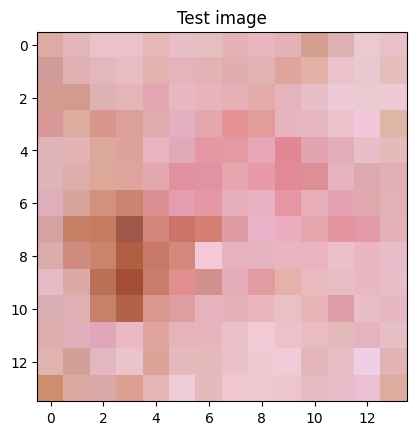

In [ ]:
plt.imshow(images_list[0])#mostramos la primera imagen cargada solo para comprobar
plt.title("Test image")
plt.show()

In [ ]:
#definimos la operacion que hara flatten a las imagenes
def flatten_image(image):
    # Convert the image to a NumPy array
    img_array = np.array(image)

    # Flatten the array
    flattened_array = img_array.flatten()

    return flattened_array

flatten_images_list=[] # lista donde se cargaran las imagenes pasadas por flatten
for image in images_list:# for que pasara todas las imagenes por flatten y las cargara a la lista
  flattened_image_array = flatten_image(image)
  flatten_images_list.append(flattened_image_array)

In [ ]:
#Test code for the validation of the sets split
flatten_images_array=np.array(flatten_images_list)
flatten_images_array.shape

(10015, 588)

 Para aplicar el primer modelo para la clasificación del cáncer, debemos contar con una variable objetivo real, a partir de la cual nuestro modelo pueda aprender. El conjunto de datos empleado en este proyecto contiene un archivo CSV, un marco de datos con dimensiones aproximadas de (10000, 2352), donde cada entrada representa una imagen y cada característica representa un píxel de una imagen redimensionada a 28x28 píxeles en escala de grises. La última característica para cada entrada contiene una etiqueta del 0 al 6, que representa la clasificación del cáncer para cada imagen. Para obtener un conjunto de entrenamiento y prueba para nuestra variable objetivo, debemos crear un nuevo marco de datos que incluya las etiquetas para cada imagen.

In [ ]:
from google.colab import files

# Upload the CSV file from your local machine
uploaded = files.upload()

In [ ]:
import shutil #not neceasry to run this cell again because the csv file already have been saved in my drive

# Specify the file path in Google Drive
drive_path = '/content/gdrive/MyDrive/CancSkin/'

# Specify the file name (change 'your_file.csv' to the actual file name)
file_name = 'hmnist_28_28_RGB.csv'

# Save the uploaded file to Google Drive
shutil.move(file_name, drive_path + file_name)

FileNotFoundError: ignored

In [ ]:
#We define the test and train sets for our target variable
dfpath='/content/gdrive/MyDrive/CancSkin/hmnist_28_28_RGB.csv'
df=pd.read_csv(dfpath)
df.tail()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,...,159,79,82,174,137,125,175,139,126,6


In [ ]:
labels=df.label.unique()
label=np.array(df['label'])
num_clas, count=np.unique(label, return_counts=True)
count_elements=[]
for element, count in zip(num_clas, count):
    print(f"{element}: {count}")
    count_elements.append(count)
count_elements=np.array(count_elements)

0: 327
1: 514
2: 1099
3: 115
4: 6705
5: 142
6: 1113


In [ ]:
print(count_elements)

[ 327  514 1099  115 6705  142 1113]


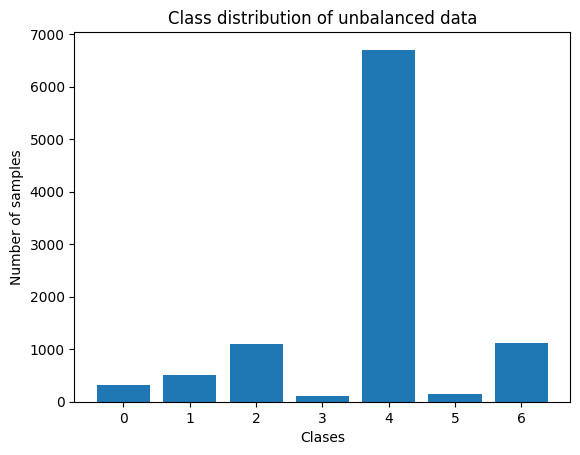

In [ ]:
plt.bar(num_clas,count_elements)
plt.xlabel("Clases")
plt.ylabel("Number of samples")
plt.title("Class distribution of unbalanced data")
plt.show()

Class 4 is clearly over represented

In [ ]:
#We start defining our training and test sets for our features and the target variable
Y=np.array(df['label'])
X_train,X_test,Y_train,Y_test= train_test_split(flatten_images_array, Y, test_size=0.2, random_state=1, shuffle=True)
print("X train , X test shpae ", X_train.shape, " ", X_test.shape)
print("Y train , Y test shpae ", Y_train.shape, " ", Y_test.shape)

X train , X test shpae  (8012, 588)   (2003, 588)
Y train , Y test shpae  (8012,)   (2003,)


In [ ]:
#Undersampling of our data
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy_dict = {
    0: 200,   # undersample class 0 to 100 samples
    1: 300,   # undersample class 1 to 200 samples
    2: 100,   # undersample class 2 to 300 samples
    3: 78,    # undersample class 3 to 50 samples
    4: 200,   # undersample class 4 to 500 samples
    5: 100,   # undersample class 5 to 150 samples
    6: 100     # undersample class 6 to 50 samples
}

rand_sampler= RandomUnderSampler(sampling_strategy = sampling_strategy_dict, random_state=1)
X_train_u, Y_train_u=rand_sampler.fit_resample(X_train,Y_train)
#We print the new shapes for our train sets
print("Before undersampling \n")
get_df_shape(X_train)
print("After undersampling \n")
get_df_shape(X_train_u)


Before undersampling 

Data set shape:  
 # of rows:  8012 
 # of columns:  588 

After undersampling 

Data set shape:  
 # of rows:  1078 
 # of columns:  588 



In [ ]:

rand_sampler= RandomUnderSampler( random_state=1)
X_train_u, Y_train_u=rand_sampler.fit_resample(X_train,Y_train)
#We print the new shapes for our train sets
print("Before undersampling \n")
get_df_shape(X_train)
print("After undersampling \n")
get_df_shape(X_train_u)

Before undersampling 

Data set shape:  
 # of rows:  8012 
 # of columns:  588 

After undersampling 

Data set shape:  
 # of rows:  546 
 # of columns:  588 



In [ ]:
#Size of balanced data
num_clas_u, count_u= np.unique(Y_train_u, return_counts=True)
count_elements_u=[]
for element, count in zip(num_clas_u, count_u):
    print(f"{element}: {count}")
    count_elements_u.append(count)
count_elements_u=np.array(count_elements_u)

0: 78
1: 78
2: 78
3: 78
4: 78
5: 78
6: 78


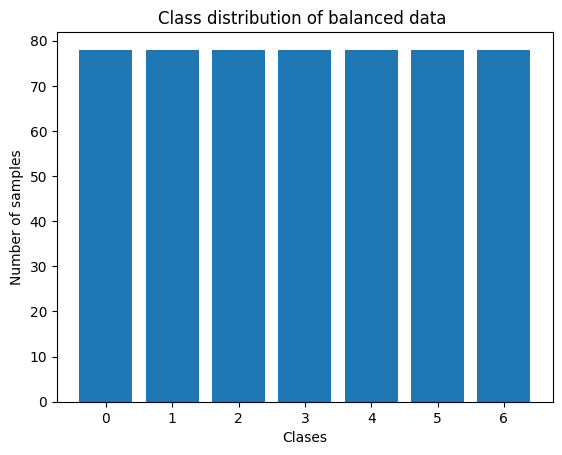

In [ ]:
plt.bar(num_clas_u,count_elements_u)
plt.xlabel("Clases")
plt.ylabel("Number of samples")
plt.title("Class distribution of balanced data ")
plt.show()

In [ ]:
def scores_multiclass(c_matrix):
  c_matrix=np.array(c_matrix)
  cum_precision=0
  cum_recall=0
  for i in range(c_matrix.shape[0]):
    for j in range (c_matrix.shape[0]):
      if i==j:
        tp=c_matrix[i,j]
        prec=tp/(np.sum(c_matrix[:,j]))
        recall=tp/(np.sum(c_matrix[i,:]))
        cum_precision=cum_precision+prec
        cum_recall=cum_recall+recall

  precision=cum_precision/c_matrix.shape[0]
  recc=cum_recall/c_matrix.shape[0]
  f1_score= 2*(precision*recc)/(precision+recc)
  return precision,recc,f1_score




In [ ]:
precision,recall,f1_score=scores_multiclass(cmm)
print("Precision, Recall, F1_Score:", precision , recall, f1_score)

Precision, Recall, F1_Score: 0.1557518141086833 0.16896572499119536 0.1620899090484478


Text(95.72222222222221, 0.5, 'true value')

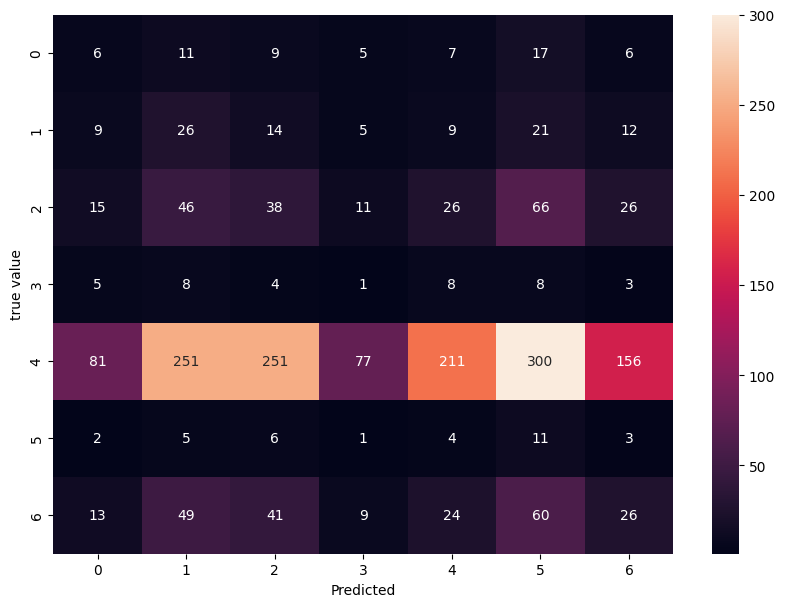

In [ ]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('true value')

# Conclusión del modelo:
En este modelo, se puede observar que no parece existir una buena predicción, ni siquiera para ciertas etiquetas específicas. El accuracy de este modelo se encuentra muy cerca del valor mínimo permitido, que es del 17%, dado por el número de etiquetas.

Visualization of actual clases for each image in the data set

Text(1066.1767676767674, 0.5, 'True')

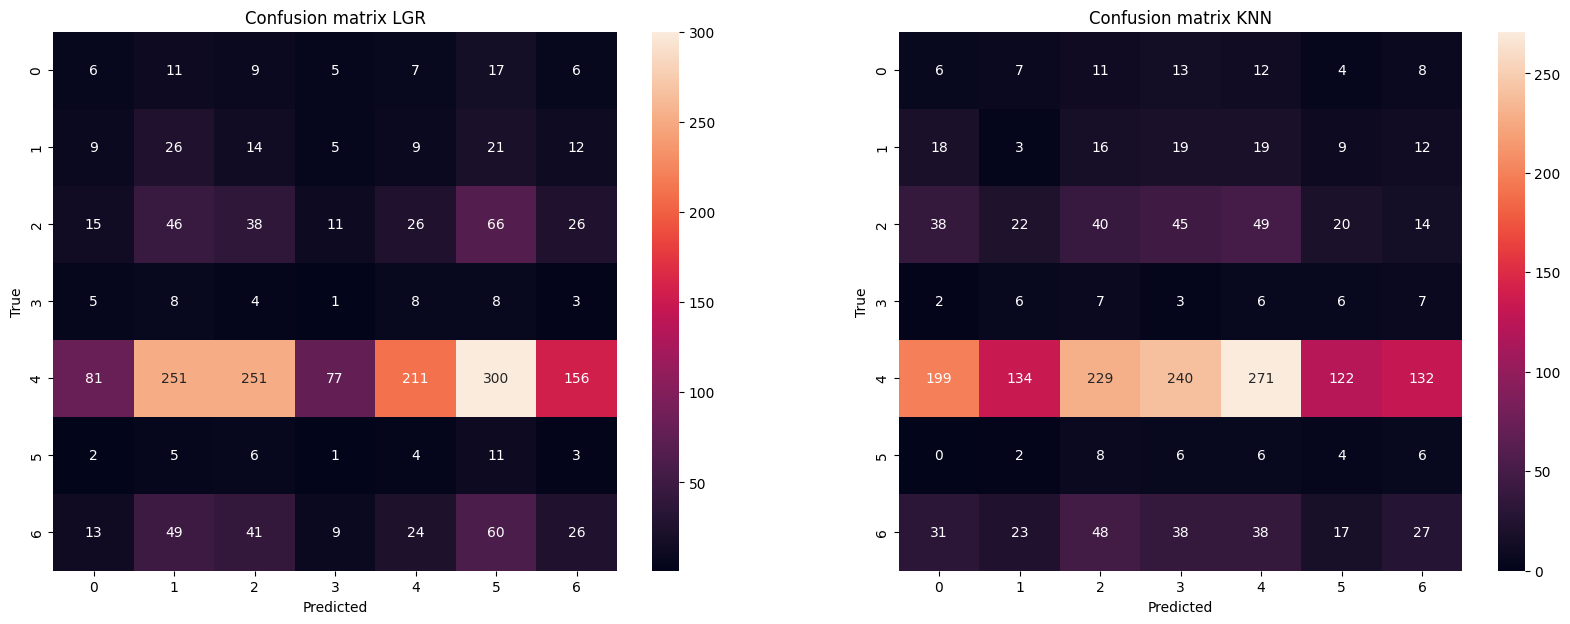

In [ ]:
#Confussion matrizx for both LGR and KNN
fig, axis=plt.subplots(1,2, figsize=(20,7))
sn.heatmap(cm,annot=True, fmt='d', ax=axis[0])
axis[0].set_title('Confusion matrix LGR')
axis[0].set_xlabel('Predicted')
axis[0].set_ylabel('True')
sn.heatmap(cm2,annot=True, fmt='d', ax=axis[1])
axis[1].set_title('Confusion matrix KNN')
axis[1].set_xlabel('Predicted')
axis[1].set_ylabel('True')

# Conclusiones LGR y KNN:
Vemos que los valores de accuracy no son muy buenos, ya que tienden al 17%, que es el valor base (equivalente a decidir al azar la etiqueta). Y aun tomando métricas como el f1-score (que, en el caso de multiclase, se puede obtener midiendo de forma binaria el recall y el f1-score, iterando entre etiquetas de 2 en 2 y luego tomando el promedio de estos), vemos que no hay un gran cambio. Asumiendo que el recall fuese del 100% (que no es el caso), el f1-score solo aumentaría alrededor del 20%. Incluso haciéndolo con el valor real de recall, se mantiene igualmente cerca del 17%, lo que nos deja igualmente un modelo ligeramente mejor, pero no decente. Esto podría mejorarse con una mayor resolución para las imágenes, pero por motivos computacionales no somos capaces de hacerlo, por lo que se exploraron mejores alternativas.



In [ ]:
#We use the dataframe to define the train and test sets
x_train,x_test,y_train,y_test= train_test_split(df.drop(columns='label'), Y, test_size=0.2, random_state=1, shuffle=True)
#We use an oversampler to balance our data
oversampler = RandomOverSampler()

x_train,y_train  = oversampler.fit_resample(x_train,y_train)
#We we reshape our training set
x_train=np.array([i.reshape(28,28,3) for i in np.array(x_train)  ])
x_test=np.array([i.reshape(28,28,3) for i in np.array(x_test)  ])


In [ ]:
y_train_encoded=to_categorical(y_train,num_classes)
y_test_encoded=to_categorical(y_test,num_classes)

In [ ]:
y_train.shape


(37646,)

In [ ]:
y_train_encoded.shape
y_test_encoded.shape

(2003, 7)

In [ ]:
#neural network for image classification
model_cnn= Sequential()
model_cnn.add(Conv2D(filters=32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model_cnn.add(MaxPool2D(pool_size = (2,2), strides=2))
model_cnn.add(tf.keras.layers.BatchNormalization())
model_cnn.add(Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model_cnn.add(MaxPool2D(pool_size = (2,2), strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=7, activation='softmax'))

In [ ]:
model_cnn.summary()

In [ ]:
#We define a callback to prevent overfitting
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True
)
checkpoint_path = "model_checkpoint/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

In [ ]:
#We compile our model
model_cnn.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[cp_callback])

In [ ]:
#We fit the model
history = model_cnn.fit( x_train,
                         y_train_encoded,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 200,
                    steep_per_epoch = 50, 
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/100
235/236 [============================>.] - ETA: 0s - loss: 1.4129 - accuracy: 0.4707

236/236 [==============================] - 24s 101ms/step - loss: 1.4128 - accuracy: 0.4707 - val_loss: 1.8557 - val_accuracy: 0.3556
Epoch 2/100
235/236 [============================>.] - ETA: 0s - loss: 1.0245 - accuracy: 0.6412

236/236 [==============================] - 24s 104ms/step - loss: 1.0243 - accuracy: 0.6413 - val_loss: 1.7705 - val_accuracy: 0.3740
Epoch 3/100
235/236 [============================>.] - ETA: 0s - loss: 0.8521 - accuracy: 0.7127

236/236 [==============================] - 22s 93ms/step - loss: 0.8522 - accuracy: 0.7126 - val_loss: 1.7442 - val_accuracy: 0.3888
Epoch 4/100
235/236 [============================>.] - ETA: 0s - loss: 0.7399 - accuracy: 0.7585

236/236 [==============================] - 25s 104ms/step - loss: 0.7398 - accuracy: 0.7586 - val_loss: 1.6986 - val_accuracy: 0.4023
Epoch 5/100
235/236 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.7906

236/236 [==============================] - 22s 93ms/step - loss: 0.6562 - accuracy: 0.7907 - val_loss: 1.1032 - val_accuracy: 0.5410
Epoch 6/100
235/236 [============================>.] - ETA: 0s - loss: 0.5863 - accuracy: 0.8180

236/236 [==============================] - 23s 99ms/step - loss: 0.5864 - accuracy: 0.8180 - val_loss: 1.3886 - val_accuracy: 0.4851
Epoch 7/100
235/236 [============================>.] - ETA: 0s - loss: 0.5309 - accuracy: 0.8385

236/236 [==============================] - 23s 96ms/step - loss: 0.5308 - accuracy: 0.8386 - val_loss: 1.2394 - val_accuracy: 0.5251
Epoch 8/100
235/236 [============================>.] - ETA: 0s - loss: 0.4798 - accuracy: 0.8585

236/236 [==============================] - 23s 96ms/step - loss: 0.4801 - accuracy: 0.8583 - val_loss: 1.1409 - val_accuracy: 0.5671
Epoch 9/100
235/236 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8728

236/236 [==============================] - 23s 99ms/step - loss: 0.4398 - accuracy: 0.8729 - val_loss: 1.2853 - val_accuracy: 0.5364
Epoch 10/100
235/236 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8866

236/236 [==============================] - 22s 93ms/step - loss: 0.4035 - accuracy: 0.8867 - val_loss: 1.0480 - val_accuracy: 0.5997
Epoch 11/100
235/236 [============================>.] - ETA: 0s - loss: 0.3745 - accuracy: 0.8952

236/236 [==============================] - 23s 99ms/step - loss: 0.3744 - accuracy: 0.8952 - val_loss: 0.9219 - val_accuracy: 0.6461
Epoch 12/100
235/236 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.9051

236/236 [==============================] - 22s 93ms/step - loss: 0.3455 - accuracy: 0.9051 - val_loss: 0.9140 - val_accuracy: 0.6485
Epoch 13/100
235/236 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.9134

236/236 [==============================] - 23s 99ms/step - loss: 0.3200 - accuracy: 0.9133 - val_loss: 0.8186 - val_accuracy: 0.6525
Epoch 14/100
235/236 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.9188

236/236 [==============================] - 23s 98ms/step - loss: 0.2986 - accuracy: 0.9188 - val_loss: 0.9120 - val_accuracy: 0.6497
Epoch 15/100
235/236 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.9256

236/236 [==============================] - 22s 95ms/step - loss: 0.2795 - accuracy: 0.9256 - val_loss: 0.8105 - val_accuracy: 0.6841
Epoch 16/100
235/236 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9297

236/236 [==============================] - 23s 99ms/step - loss: 0.2595 - accuracy: 0.9297 - val_loss: 1.0560 - val_accuracy: 0.6024
Epoch 17/100
235/236 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9350

236/236 [==============================] - 22s 93ms/step - loss: 0.2444 - accuracy: 0.9351 - val_loss: 0.9321 - val_accuracy: 0.6287
Epoch 18/100
235/236 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9389

236/236 [==============================] - 23s 99ms/step - loss: 0.2296 - accuracy: 0.9389 - val_loss: 0.8305 - val_accuracy: 0.6579
Epoch 19/100
235/236 [============================>.] - ETA: 0s - loss: 0.2157 - accuracy: 0.9435

236/236 [==============================] - 22s 94ms/step - loss: 0.2159 - accuracy: 0.9435 - val_loss: 0.8427 - val_accuracy: 0.6625
Epoch 20/100
235/236 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9460

236/236 [==============================] - 24s 100ms/step - loss: 0.2046 - accuracy: 0.9459 - val_loss: 0.7903 - val_accuracy: 0.6611
Epoch 21/100
236/236 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9501

236/236 [==============================] - 25s 106ms/step - loss: 0.1922 - accuracy: 0.9501 - val_loss: 0.7652 - val_accuracy: 0.6900
Epoch 22/100
235/236 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9530

236/236 [==============================] - 25s 104ms/step - loss: 0.1809 - accuracy: 0.9529 - val_loss: 0.8145 - val_accuracy: 0.6632
Epoch 23/100
235/236 [============================>.] - ETA: 0s - loss: 0.1742 - accuracy: 0.9552

236/236 [==============================] - 23s 98ms/step - loss: 0.1741 - accuracy: 0.9552 - val_loss: 0.8779 - val_accuracy: 0.6570
Epoch 24/100
235/236 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9568

236/236 [==============================] - 25s 105ms/step - loss: 0.1639 - accuracy: 0.9568 - val_loss: 0.5132 - val_accuracy: 0.7801
Epoch 25/100
235/236 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9582

236/236 [==============================] - 22s 93ms/step - loss: 0.1569 - accuracy: 0.9582 - val_loss: 0.5842 - val_accuracy: 0.7408
Epoch 26/100
236/236 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9613

236/236 [==============================] - 27s 116ms/step - loss: 0.1484 - accuracy: 0.9613 - val_loss: 0.6654 - val_accuracy: 0.7189
Epoch 27/100
235/236 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9623

236/236 [==============================] - 27s 113ms/step - loss: 0.1426 - accuracy: 0.9623 - val_loss: 0.5719 - val_accuracy: 0.7648
Epoch 28/100
235/236 [============================>.] - ETA: 0s - loss: 0.1364 - accuracy: 0.9637

236/236 [==============================] - 24s 100ms/step - loss: 0.1365 - accuracy: 0.9637 - val_loss: 0.5877 - val_accuracy: 0.7409
Epoch 29/100
235/236 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9653

236/236 [==============================] - 23s 99ms/step - loss: 0.1303 - accuracy: 0.9653 - val_loss: 0.7275 - val_accuracy: 0.7008
Epoch 30/100
235/236 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9674

236/236 [==============================] - 24s 100ms/step - loss: 0.1238 - accuracy: 0.9674 - val_loss: 0.8103 - val_accuracy: 0.6679
Epoch 31/100
235/236 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9688

236/236 [==============================] - 23s 98ms/step - loss: 0.1191 - accuracy: 0.9688 - val_loss: 0.5382 - val_accuracy: 0.7734
Epoch 32/100
235/236 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.9696

236/236 [==============================] - 23s 96ms/step - loss: 0.1134 - accuracy: 0.9696 - val_loss: 0.6316 - val_accuracy: 0.7319
Epoch 33/100
235/236 [============================>.] - ETA: 0s - loss: 0.1084 - accuracy: 0.9711

236/236 [==============================] - 23s 99ms/step - loss: 0.1083 - accuracy: 0.9711 - val_loss: 0.6272 - val_accuracy: 0.7386
Epoch 34/100
235/236 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9719

236/236 [==============================] - 22s 93ms/step - loss: 0.1054 - accuracy: 0.9719 - val_loss: 0.6986 - val_accuracy: 0.7131
Epoch 35/100
235/236 [============================>.] - ETA: 0s - loss: 0.1009 - accuracy: 0.9720

236/236 [==============================] - 25s 105ms/step - loss: 0.1010 - accuracy: 0.9720 - val_loss: 0.6532 - val_accuracy: 0.7161
Epoch 36/100
235/236 [============================>.] - ETA: 0s - loss: 0.0960 - accuracy: 0.9739

236/236 [==============================] - 29s 122ms/step - loss: 0.0961 - accuracy: 0.9739 - val_loss: 0.8276 - val_accuracy: 0.6643
Epoch 37/100
235/236 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9748

236/236 [==============================] - 25s 104ms/step - loss: 0.0931 - accuracy: 0.9747 - val_loss: 0.5287 - val_accuracy: 0.7687
Epoch 38/100
236/236 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9761

236/236 [==============================] - 29s 121ms/step - loss: 0.0889 - accuracy: 0.9761 - val_loss: 0.4141 - val_accuracy: 0.8327
Epoch 39/100
235/236 [============================>.] - ETA: 0s - loss: 0.0853 - accuracy: 0.9777

236/236 [==============================] - 28s 121ms/step - loss: 0.0853 - accuracy: 0.9778 - val_loss: 0.4016 - val_accuracy: 0.8433
Epoch 40/100
235/236 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9785

236/236 [==============================] - 28s 120ms/step - loss: 0.0811 - accuracy: 0.9784 - val_loss: 0.3425 - val_accuracy: 0.8588
Epoch 41/100
236/236 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9785

236/236 [==============================] - 35s 150ms/step - loss: 0.0798 - accuracy: 0.9785 - val_loss: 0.3367 - val_accuracy: 0.8655
Epoch 42/100
235/236 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9794

236/236 [==============================] - 31s 133ms/step - loss: 0.0760 - accuracy: 0.9794 - val_loss: 0.5431 - val_accuracy: 0.7616
Epoch 43/100
235/236 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9803

236/236 [==============================] - 30s 127ms/step - loss: 0.0726 - accuracy: 0.9802 - val_loss: 0.4527 - val_accuracy: 0.8203
Epoch 44/100
235/236 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9808

236/236 [==============================] - 24s 102ms/step - loss: 0.0707 - accuracy: 0.9808 - val_loss: 0.4976 - val_accuracy: 0.7951
Epoch 45/100
235/236 [============================>.] - ETA: 0s - loss: 0.0687 - accuracy: 0.9822

236/236 [==============================] - 23s 95ms/step - loss: 0.0687 - accuracy: 0.9822 - val_loss: 0.5771 - val_accuracy: 0.7502
Epoch 46/100
235/236 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9826

236/236 [==============================] - 24s 100ms/step - loss: 0.0665 - accuracy: 0.9825 - val_loss: 0.2901 - val_accuracy: 0.8985
Epoch 47/100
235/236 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9832

236/236 [==============================] - 22s 94ms/step - loss: 0.0640 - accuracy: 0.9832 - val_loss: 0.4742 - val_accuracy: 0.7918
Epoch 48/100
235/236 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9844

236/236 [==============================] - 24s 103ms/step - loss: 0.0601 - accuracy: 0.9844 - val_loss: 0.3781 - val_accuracy: 0.8550
Epoch 49/100
236/236 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9855

236/236 [==============================] - 42s 176ms/step - loss: 0.0568 - accuracy: 0.9855 - val_loss: 0.2330 - val_accuracy: 0.9240
Epoch 50/100
235/236 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9863

236/236 [==============================] - 25s 105ms/step - loss: 0.0553 - accuracy: 0.9863 - val_loss: 0.2257 - val_accuracy: 0.9234
Epoch 51/100
235/236 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9863

236/236 [==============================] - 23s 99ms/step - loss: 0.0536 - accuracy: 0.9863 - val_loss: 0.3135 - val_accuracy: 0.8839
Epoch 52/100
235/236 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9872

236/236 [==============================] - 24s 101ms/step - loss: 0.0515 - accuracy: 0.9872 - val_loss: 0.1443 - val_accuracy: 0.9478
Epoch 53/100
235/236 [============================>.] - ETA: 0s - loss: 0.0506 - accuracy: 0.9876

236/236 [==============================] - 22s 94ms/step - loss: 0.0506 - accuracy: 0.9876 - val_loss: 0.3572 - val_accuracy: 0.8614
Epoch 54/100
235/236 [============================>.] - ETA: 0s - loss: 0.0467 - accuracy: 0.9884

236/236 [==============================] - 25s 104ms/step - loss: 0.0467 - accuracy: 0.9884 - val_loss: 0.2689 - val_accuracy: 0.8988
Epoch 55/100
235/236 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9891

236/236 [==============================] - 23s 98ms/step - loss: 0.0459 - accuracy: 0.9891 - val_loss: 0.2194 - val_accuracy: 0.9238
Epoch 56/100
235/236 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9892

236/236 [==============================] - 23s 98ms/step - loss: 0.0450 - accuracy: 0.9892 - val_loss: 0.3139 - val_accuracy: 0.8833
Epoch 57/100
235/236 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9895

236/236 [==============================] - 26s 111ms/step - loss: 0.0431 - accuracy: 0.9895 - val_loss: 0.1361 - val_accuracy: 0.9503
Epoch 58/100
236/236 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9910

236/236 [==============================] - 25s 105ms/step - loss: 0.0412 - accuracy: 0.9910 - val_loss: 0.4942 - val_accuracy: 0.7647
Epoch 59/100
235/236 [============================>.] - ETA: 0s - loss: 0.0386 - accuracy: 0.9912

236/236 [==============================] - 22s 95ms/step - loss: 0.0386 - accuracy: 0.9912 - val_loss: 0.1093 - val_accuracy: 0.9681
Epoch 60/100
235/236 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9916

236/236 [==============================] - 24s 101ms/step - loss: 0.0379 - accuracy: 0.9916 - val_loss: 0.3071 - val_accuracy: 0.8825
Epoch 61/100
235/236 [============================>.] - ETA: 0s - loss: 0.0363 - accuracy: 0.9918

236/236 [==============================] - 22s 94ms/step - loss: 0.0364 - accuracy: 0.9917 - val_loss: 0.2446 - val_accuracy: 0.9155
Epoch 62/100
235/236 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9925

236/236 [==============================] - 24s 101ms/step - loss: 0.0351 - accuracy: 0.9925 - val_loss: 0.1937 - val_accuracy: 0.9320
Epoch 63/100
235/236 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9931

236/236 [==============================] - 24s 104ms/step - loss: 0.0329 - accuracy: 0.9931 - val_loss: 0.2263 - val_accuracy: 0.9189
Epoch 64/100
235/236 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9931

236/236 [==============================] - 22s 94ms/step - loss: 0.0319 - accuracy: 0.9931 - val_loss: 0.2242 - val_accuracy: 0.9199
Epoch 65/100
235/236 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9933

236/236 [==============================] - 24s 101ms/step - loss: 0.0310 - accuracy: 0.9933 - val_loss: 0.1845 - val_accuracy: 0.9382
Epoch 66/100
235/236 [============================>.] - ETA: 0s - loss: 0.0293 - accuracy: 0.9942

236/236 [==============================] - 22s 93ms/step - loss: 0.0293 - accuracy: 0.9942 - val_loss: 0.2685 - val_accuracy: 0.8919
Epoch 67/100
235/236 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9945

236/236 [==============================] - 24s 101ms/step - loss: 0.0287 - accuracy: 0.9945 - val_loss: 0.1595 - val_accuracy: 0.9465
Epoch 68/100
235/236 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9947

236/236 [==============================] - 23s 97ms/step - loss: 0.0269 - accuracy: 0.9947 - val_loss: 0.1800 - val_accuracy: 0.9356
Epoch 69/100
235/236 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9952

236/236 [==============================] - 23s 97ms/step - loss: 0.0253 - accuracy: 0.9953 - val_loss: 0.2056 - val_accuracy: 0.9222
Epoch 70/100
235/236 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9956

236/236 [==============================] - 24s 100ms/step - loss: 0.0249 - accuracy: 0.9956 - val_loss: 0.1127 - val_accuracy: 0.9611
Epoch 71/100
235/236 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9955

236/236 [==============================] - 22s 94ms/step - loss: 0.0244 - accuracy: 0.9955 - val_loss: 0.1689 - val_accuracy: 0.9481
Epoch 72/100
235/236 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9958

236/236 [==============================] - 24s 102ms/step - loss: 0.0238 - accuracy: 0.9958 - val_loss: 0.0698 - val_accuracy: 0.9789
Epoch 73/100
235/236 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9962

236/236 [==============================] - 24s 100ms/step - loss: 0.0219 - accuracy: 0.9962 - val_loss: 0.0843 - val_accuracy: 0.9802
Epoch 74/100
235/236 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9961

236/236 [==============================] - 23s 97ms/step - loss: 0.0208 - accuracy: 0.9961 - val_loss: 0.1474 - val_accuracy: 0.9506
Epoch 75/100
235/236 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9967

236/236 [==============================] - 24s 103ms/step - loss: 0.0203 - accuracy: 0.9967 - val_loss: 0.2132 - val_accuracy: 0.9194
Epoch 76/100
235/236 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9971

236/236 [==============================] - 23s 96ms/step - loss: 0.0188 - accuracy: 0.9971 - val_loss: 0.0950 - val_accuracy: 0.9774
Epoch 77/100
235/236 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9969

236/236 [==============================] - 24s 102ms/step - loss: 0.0189 - accuracy: 0.9969 - val_loss: 0.0955 - val_accuracy: 0.9732
Epoch 78/100
235/236 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9972

236/236 [==============================] - 25s 106ms/step - loss: 0.0185 - accuracy: 0.9972 - val_loss: 0.0962 - val_accuracy: 0.9612
Epoch 79/100
235/236 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9975

236/236 [==============================] - 23s 96ms/step - loss: 0.0174 - accuracy: 0.9974 - val_loss: 0.1246 - val_accuracy: 0.9656
Epoch 80/100
235/236 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9973

236/236 [==============================] - 24s 101ms/step - loss: 0.0161 - accuracy: 0.9973 - val_loss: 0.0628 - val_accuracy: 0.9896
Epoch 81/100
235/236 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9980

236/236 [==============================] - 24s 102ms/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.0914 - val_accuracy: 0.9761
Epoch 82/100
235/236 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9979

236/236 [==============================] - 24s 103ms/step - loss: 0.0148 - accuracy: 0.9979 - val_loss: 0.1098 - val_accuracy: 0.9774
Epoch 83/100
235/236 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9983

236/236 [==============================] - 24s 102ms/step - loss: 0.0140 - accuracy: 0.9983 - val_loss: 0.0700 - val_accuracy: 0.9845
Epoch 84/100
235/236 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9980

236/236 [==============================] - 24s 100ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.1378 - val_accuracy: 0.9592
Epoch 85/100
235/236 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9984

236/236 [==============================] - 25s 105ms/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.0234 - val_accuracy: 0.9981
Epoch 86/100
235/236 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9989

236/236 [==============================] - 25s 108ms/step - loss: 0.0119 - accuracy: 0.9989 - val_loss: 0.0638 - val_accuracy: 0.9882
Epoch 87/100
235/236 [============================>.] - ETA: 0s - loss: 0.0127 - accuracy: 0.9984

236/236 [==============================] - 23s 99ms/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.0248 - val_accuracy: 0.9989
Epoch 88/100
235/236 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9990

236/236 [==============================] - 23s 99ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.0446 - val_accuracy: 0.9939
Epoch 89/100
235/236 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9992

236/236 [==============================] - 24s 103ms/step - loss: 0.0106 - accuracy: 0.9991 - val_loss: 0.1289 - val_accuracy: 0.9623
Epoch 90/100
235/236 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9985

236/236 [==============================] - 23s 100ms/step - loss: 0.0114 - accuracy: 0.9985 - val_loss: 0.0661 - val_accuracy: 0.9855
Epoch 91/100
235/236 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9991

236/236 [==============================] - 24s 103ms/step - loss: 0.0099 - accuracy: 0.9991 - val_loss: 0.1892 - val_accuracy: 0.9114
Epoch 92/100
235/236 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9989

236/236 [==============================] - 25s 106ms/step - loss: 0.0107 - accuracy: 0.9989 - val_loss: 0.0441 - val_accuracy: 0.9920
Epoch 93/100
235/236 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9994

236/236 [==============================] - 25s 104ms/step - loss: 0.0086 - accuracy: 0.9994 - val_loss: 0.0204 - val_accuracy: 0.9995
Epoch 94/100
235/236 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9994

236/236 [==============================] - 24s 102ms/step - loss: 0.0083 - accuracy: 0.9994 - val_loss: 0.1292 - val_accuracy: 0.9611
Epoch 95/100
235/236 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9995

236/236 [==============================] - 25s 104ms/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.0312 - val_accuracy: 0.9976
Epoch 96/100
235/236 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9995

236/236 [==============================] - 24s 102ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.0555 - val_accuracy: 0.9904
Epoch 97/100
235/236 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9991

236/236 [==============================] - 24s 100ms/step - loss: 0.0082 - accuracy: 0.9991 - val_loss: 0.1856 - val_accuracy: 0.9205
Epoch 98/100
235/236 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9995

236/236 [==============================] - 25s 105ms/step - loss: 0.0068 - accuracy: 0.9995 - val_loss: 0.0364 - val_accuracy: 0.9964
Epoch 99/100
235/236 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9996

236/236 [==============================] - 25s 104ms/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 0.0168 - val_accuracy: 0.9992
Epoch 100/100
235/236 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9996

236/236 [==============================] - 25s 107ms/step - loss: 0.0064 - accuracy: 0.9996 - val_loss: 0.0159 - val_accuracy: 1.0000


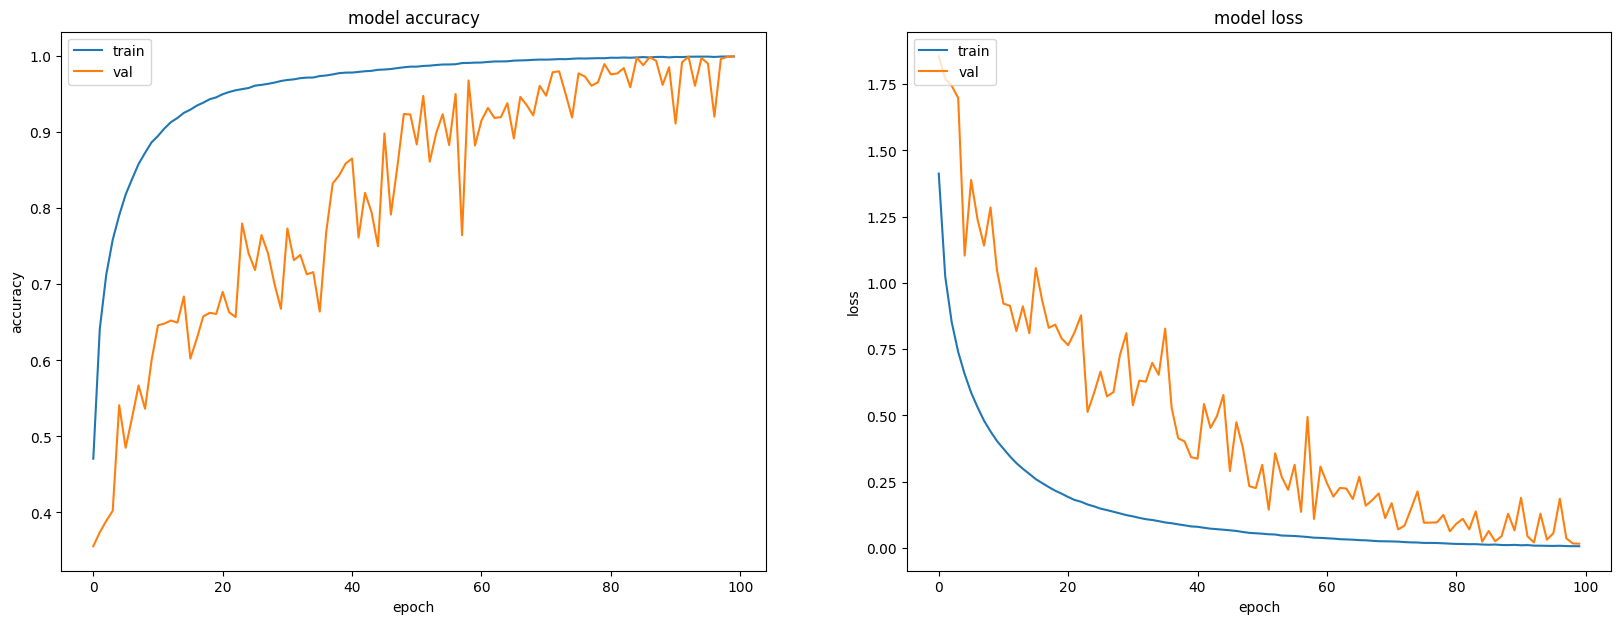

In [ ]:
#We evaluate our model
fig, axis= plt.subplots(1,2 ,figsize=(20,7))

axis[0].plot(history.history['accuracy'])
axis[0].plot(history.history['val_accuracy'])
axis[0].set_title('model accuracy')
axis[0].set_ylabel('accuracy')
axis[0].set_xlabel('epoch')
axis[0].legend(['train', 'val'], loc='upper left')

axis[1].plot(history.history['loss'])
axis[1].plot(history.history['val_loss'])
axis[1].set_title('model loss')
axis[1].set_ylabel('loss')
axis[1].set_xlabel('epoch')
axis[1].legend(['train', 'val'], loc='upper left')


In [ ]:
loss_test, acc_test = model_cnn.evaluate(x_test, y_test_encoded, verbose=1)
loss_train, acc_train = model_cnn.evaluate(x_train, y_train_encoded, verbose=1)

1177/1177 [==============================] - 13s 11ms/step - loss: 0.0083 - accuracy: 1.0000


Low accuracy on the test set might be due to overfitting

In [ ]:
#We define a predicted set and plot our confussion matrices
cnn_pred=model_cnn.predict(x_test)
cnn_pred_labels= [np.argmax(i) for i in np.array(cnn_pred)]
cm3=tf.math.confusion_matrix(labels=Y_test, predictions= cnn_pred_labels)
cnn_pred_train=model_cnn.predict(x_train)
cnn_pred_labels_train= [np.argmax(i) for i in np.array(cnn_pred_train)]
cm4=tf.math.confusion_matrix(labels=y_train, predictions= cnn_pred_labels_train)

1177/1177 [==============================] - 11s 9ms/step


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define your CNN model
def create_model():
    model_cnn = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=7, activation='softmax')
    ])
    return model_cnn


# Define function to train and evaluate model
def train_evaluate_model(X_train, y_train, X_test, y_test,num_model):
    model = create_model()
    checkpoint_path = f"model_{num_model}_checkpoint/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[cp_callback])

    eval_metrics = model.evaluate(X_test, y_test)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    auc_score = auc(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    loss = eval_metrics[0]

    cm = confusion_matrix(y_test, y_pred_classes)

    return acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred_classes,history



# Define function to plot AUC-ROC and Precision-Recall curves
def plot_curves(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob[:, 1])

    plt.figure(figsize=(10, 5))

    # Plot AUC-ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Load your data (X, y) here

# Define lists to store evaluation metrics
acc_scores = []
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
mcc_scores = []
loss_scores = []
cm_list = []
y_pred_list = []
history_list=[]
# Define Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred,history = train_evaluate_model(X_train, y_train, X_test, y_test)

    acc_scores.append(acc)
    auc_scores.append(auc_score)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    loss_scores.append(loss)
    cm_list.append(cm)
    y_pred_list.append(y_pred)
    history_list.append(history)

# Calculate mean and standard deviation for each metric
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_mcc = np.mean(mcc_scores)
std_mcc = np.std(mcc_scores)

mean_loss = np.mean(loss_scores)
std_loss = np.std(loss_scores)

# Display results in a table
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC", "Loss"],
    "Mean": [mean_acc, mean_auc, mean_precision, mean_recall, mean_f1, mean_mcc, mean_loss],
    "Std Dev": [std_acc, std_auc, std_precision, std_recall, std_f1, std_mcc, std_loss]
})

print("Performance Metrics:")
print(results_df)

# Display confusion matrix of the best model
best_auc_index = np.argmax(auc_scores)
best_cm = cm_list[best_auc_index]
print("\nConfusion Matrix of the Best Model (Maximized AUC):")
print(best_cm)

#Best prediction
best_y_pred = y_pred_list[best_auc_index]
# Plot AUC-ROC and Precision-Recall curves for the best model
plot_curves(y_test, best_y_pred)

history=history_list[best_auc_index]
# Plot mean loss vs epochs for training and validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['train_loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.title('Mean Loss vs Epochs')
plt.legend()
plt.show()

Text(1066.1767676767674, 0.5, 'True')

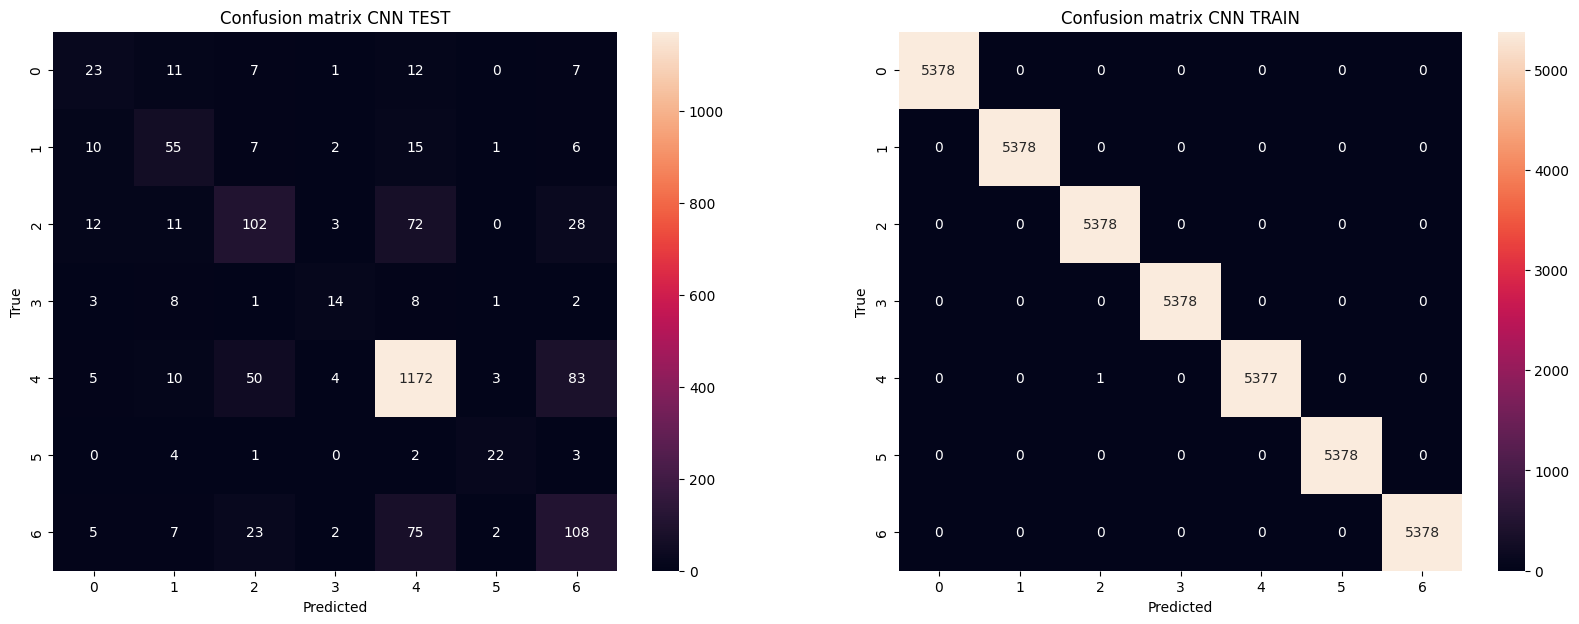

In [ ]:
fig, axis=plt.subplots(1,2, figsize=(20,7))
sn.heatmap(cm3,annot=True, fmt='d', ax=axis[0])
axis[0].set_title('Confusion matrix CNN TEST')
axis[0].set_xlabel('Predicted')
axis[0].set_ylabel('True')
sn.heatmap(cm4,annot=True, fmt='d', ax=axis[1])
axis[1].set_title('Confusion matrix CNN TRAIN')
axis[1].set_xlabel('Predicted')
axis[1].set_ylabel('True')

In [ ]:
cmm2=[[ 23, 11,  7,  1, 12,  0, 7],
     [ 10, 55,  7,  2, 15,  1,  6],
     [ 12, 11,102,  3, 72,  0, 28],
     [  3,  8,  1, 14,  8,  1,  2],
     [  5, 10, 50,  4, 1172,3, 83],
     [  0,  4,  1,  0,  2, 22,  3],
     [  5,  7, 23,  2, 75,  2,108],]
precision,recall,f1_score=scores_multiclass(cmm2)
print("Precision, Recall, F1_Score:", precision , recall, f1_score)

Precision, Recall, F1_Score: 0.5809337539411317 0.5475563300004593 0.5637514388613095


In [ ]:
x_test.shape

(2003, 28, 28, 3)

In [ ]:
y_test.shape

(2003,)

In [ ]:
#Data visualization using tsne for true labels
m= TSNE(learning_rate=50)
tsn_features_test= m.fit_transform(x_test.reshape(2003,2352))

In [ ]:
sns_markers={0:"akiec",1: "bcc",2:"bkl",3:"df",4:"nv",5:"vasc",6:"mel"}
sns_hue=[sns_markers[i] for i in y_test]
sns_hue_pred=[sns_markers[i] for i in cnn_pred_labels]

Text(0.5, 1.0, 'Predicted Test Labels')

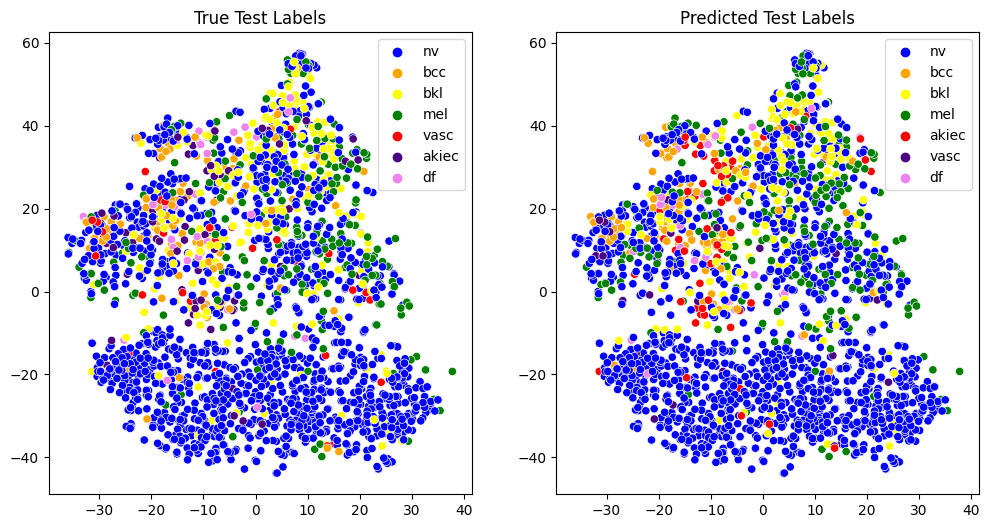

In [ ]:
custom_colors = ['blue', 'orange', 'yellow', 'green', 'red', 'indigo', 'violet']
fig, axis=plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x=tsn_features_test[0:,0], y=tsn_features_test[0:,1],hue=sns_hue, palette=custom_colors, markers=sns_markers ,ax=axis[0])
axis[0].set_title('True Test Labels')
sns.scatterplot(x=tsn_features_test[0:,0], y=tsn_features_test[0:,1],hue=sns_hue_pred, palette=custom_colors, markers=sns_markers,ax=axis[1])
axis[1].set_title('Predicted Test Labels')

Type of cancer, True type:  ('nv', ' melanocytic nevi') Predicted type:  ('nv', ' melanocytic nevi')


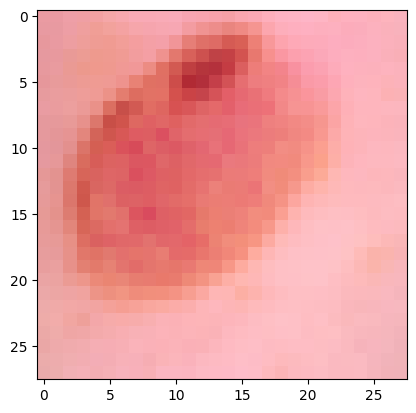

In [ ]:
#Let's make a prediction with our model
im=x_test[1]
plt.imshow(im)
true_label=y_test[1]
prediction= cnn_pred_labels[1]
print("Type of cancer, True type: ", classes[true_label], "Predicted type: ",classes[prediction])

Type of cancer, True type:  ('nv', ' melanocytic nevi') Predicted type:  ('nv', ' melanocytic nevi')


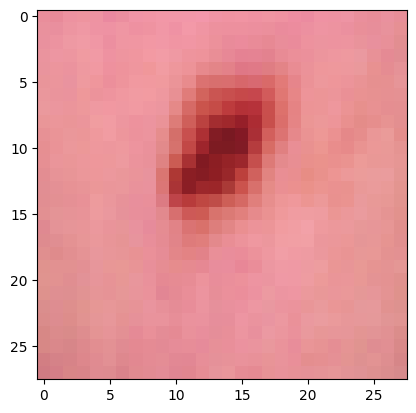

In [ ]:
ind=random.randint(1, 2003)
im=x_test[ind]
plt.imshow(im)
true_label=y_test[ind]
prediction= cnn_pred_labels[ind]
print("Type of cancer, True type: ", classes[true_label], "Predicted type: ",classes[prediction])

# Conclusion del modelo:

El accuracy de este modelo para los conjuntos de test y tran parece indicar un sobre ajuste, lo cual puede deberse a la sobre representación de la clase 4 en nuestro conjunto de datos. Al analizar las matrices de confusión graficadas para los conjuntos de entrenamiento y test podemos ver que el modelo predice casi perfectamente la clasificación de las imágenes en el conjunto de entrenamiento, mientras que para el conjunto de prueba la precisión y el recall  fueron de 0.55

En conclusión, al analizar las diferencias entre los modelos es posible decir que:
- El problema de clasificación de imágenes puede resultar muy complejo para analizar con clasificadores comunes, y que una red neuronal resulta mucho más efectiva a la hora de clasificar imágenes, puesto que; clasificadores como LGR o KNN realizan una comparación asignado pesos iguales a cada característica de nuestros datos, en este caso píxeles, mientras que las redes neuronales son más dinámicas a la hora de asignar estos pesos, como se pudo ver al utilizar Conv2D y Maxpool, puesto que estas son herramientas que se basan en reconocer patrones para cada imagen, esto podría llegar a ser una especie de feature selection personalizada, ya que escojemos las mejores características para cada muestra.
- Tanto el PCA como el parameter Tunning y el feature selection,  con sus herramientas correspondientes no garantizan mejorar considerablemente el performance de nuestro modelo, como se vio en las métricas de nuestros dos primeros modelos.
-Tanto PCA como TSNe son técnicas de reducción de dimensionalidad, y si bien no siempre aseguran evitar el sobreajuste, permiten reducir el poder computacional necesario para analizar las características más importantes de nuestros
-Tanto KNN como LGR no resultan eficientes a la hora de clasificar imágenes puesto que su performance es mediocre y el tiempo de ejecución necesario para optimizar sus parámetros, implementar kfold cross validation, y entrenar el modelo es en extremo largo.
-En lo personal considero que muchos aspectos del trabajo pudieron mejorarse solo con implementar el código en otro ambiente de programación como Vs_code, puesto que por el uso de Ram y almacenamiento muchos aspectos como incluir diferentes métricas e implementar reapeated kfold.

##Referencias


[1]A. Sharma, "Convolutional Neural Networks in Python with Keras," DataCamp, Dec. 2017. [Online]. Available: https://www.datacamp.com/tutorial/convolutional-neural-networks-python. (Accedido el 11/12/2023).

[2]K. Bharat, "Introduction to Deep Neural Networks," DataCamp, Jul. 2023. [Online]. Available: https://www.datacamp.com/tutorial/introduction-to-deep-neural-networks. (Accedido el 11/12/2023).

[3]A. Awan, "Introduction to t-SNE," DataCamp, Mar. 2023. [Online]. Available: https://www.datacamp.com/tutorial/introduction-t-sne. (Accedido el 11/12/2023).

[4]American Cancer Society, "Estadísticas importantes sobre el cáncer de piel tipo melanoma," American Cancer Society, 2023. [Online]. Available: https://www.cancer.org/es/cancer/tipos/cancer-de-piel-tipo-melanoma/acerca/estadisticas-clave.html. (Accedido el 11/12/2023).

[5]M. Dildar et al., "Skin cancer detection: a review using deep learning techniques," International Journal of Environmental Research and Public Health, vol. 18, no. 10, p. 5479, 2021.

[6]A. Esteva et al., "Dermatologist-level classification of skin cancer with deep neural networks," Nature, vol. 542, pp. 115–118, 2017. https://doi.org/10.1038/nature21056

[7]R. MurtiRawat et al., "Breast Cancer Detection Using K-Nearest Neighbors, Logistic Regression and Ensemble Learning",  presented at 2020 International Conference on Electronics and Sustainable Communication, Coimbatore, India,2020.